In [1]:
# -*- coding: utf-8 -*-
"""
This code outlines very a very basic use case for the NetworkSedimentTransporter
component, including adding new sediment mid-run. 

Last updated: 5/16/2020

@authors: AMP
"""
import matplotlib.pyplot as plt
import numpy as np
import time as measuretime
import copy

from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import plot_network_and_parcels

_OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1

In [2]:
# %% STEP 1: create grid. 
x_of_node = np.arange(0,1000,100)
y_of_node = np.zeros_like(x_of_node)

nodes_at_link = []
for i in range(np.size(y_of_node)-1): 
    nodes_at_link.append((i,i+1))

grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)
#plt.figure(0)
#graph.plot_graph(grid, at="node,link")

grid.at_node["topographic__elevation"] = 10-x_of_node*0.01

grid.at_node["bedrock__elevation"] = 10-x_of_node*0.01

grid.add_field("flow_depth", 3*np.ones(grid.size("link")), at="link")

area = grid.add_ones("cell_area_at_node", at="node")

# Set geometry for each link
grid.at_link["drainage_area"] = np.ones(grid.number_of_links) # m2
grid.at_link["channel_slope"] = np.ones(grid.number_of_links)
grid.at_link["reach_length"] = 500*np.ones(grid.number_of_links)  # m
grid.at_link["channel_width"] = 1*np.ones(grid.number_of_links)

In [3]:
time = [0.0]  

element_id = np.repeat(np.arange(grid.number_of_links),50)
element_id = np.expand_dims(element_id, axis=1)

np.random.seed(0)

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
starting_link = np.squeeze(element_id)
volume = 1*np.ones(np.shape(element_id))  
lithology = ["quartzite"] * np.size(element_id)
active_layer = np.ones(np.shape(element_id))
density = 2650 * np.ones(np.size(element_id))
location_in_link = np.random.rand(np.size(element_id), 1) 
abrasion_rate = 0 * np.ones(np.size(element_id))

# Lognormal GSD
medianD = 0.065
mu = np.log(medianD)
sigma = np.log(1.5) #assume that D84 = x*D50
D = np.random.lognormal(mu,sigma,np.shape(element_id))

items = {"grid_element": "link", "element_id": element_id}

variables = {
    "starting_link": (["item_id"], starting_link),
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume),
}

parcels = DataRecord(
    grid,
    items=items,
    time=time,
    data_vars=variables,
    dummy_elements={"link": [_OUT_OF_NETWORK]},
)
parcels_ini=copy.deepcopy(parcels)

In [4]:
print(len(variables['starting_link'][1]))
time

450


[0.0]

In [5]:

fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

nst = NetworkSedimentTransporter(  
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)


In [6]:
def add_new_parcels(num_pulse_parcels,nst):
        newpar_element_id = np.zeros(num_pulse_parcels,dtype=int)
        newpar_element_id = np.expand_dims(newpar_element_id, axis=1)
        
        new_starting_link = np.squeeze(newpar_element_id)
        
        np.random.seed(0)
        
        new_time_arrival_in_link = nst._time* np.ones(
            np.shape(newpar_element_id)) 
        
        new_volume = 0.05*np.ones(np.shape(newpar_element_id))  # (m3) the volume of each parcel
        
        new_lithology = ["pulse_material"] * np.size(
            newpar_element_id
        )  # a lithology descriptor for each parcel
        
        new_active_layer = np.ones(
            np.shape(newpar_element_id)
        )  # 1 = active/surface layer; 0 = subsurface layer
        
        new_density = 2650 * np.ones(np.size(newpar_element_id))  # (kg/m3)
        
        new_location_in_link = np.random.rand(
            np.size(newpar_element_id), 1
        )/3

        new_abrasion_rate = 0 * np.ones(np.size(newpar_element_id))
        
        #new_D = 0.03 * np.ones(np.shape(newpar_element_id))

        new_D = np.random.lognormal(np.log(0.02),np.log(2.1),np.shape(newpar_element_id))
        
        newpar_grid_elements = np.array(
            np.empty(
                (np.shape(newpar_element_id)), dtype=object
            )
        ) # BUG: should be able to pass ["link"], but datarecord fills it into an incorrect array shape-- the length of parcels (NOT new parcels)
        newpar_grid_elements.fill("link")
        
        new_parcels = {"grid_element": newpar_grid_elements,
                 "element_id": newpar_element_id}
        
        new_variables = {
            "starting_link": (["item_id"], new_starting_link),
            "abrasion_rate": (["item_id"], new_abrasion_rate),
            "density": (["item_id"], new_density),
            "lithology": (["item_id"], new_lithology),
            "time_arrival_in_link": (["item_id", "time"], new_time_arrival_in_link),
            "active_layer": (["item_id", "time"], new_active_layer),
            "location_in_link": (["item_id", "time"], new_location_in_link),
            "D": (["item_id", "time"], new_D),
            "volume": (["item_id", "time"], new_volume),
        }
        
        parcels.add_item(
                time=[nst._time],
                new_item = new_parcels,
                new_item_spec = new_variables
        )   
        
        return new_parcels,nst

c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:541: RuntimeWarning: invalid value encountered in power
  0.515 * self._d_mean_active * (3.09 * (taustar - 0.0549) ** 0.56)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:854: RuntimeWarning: invalid value encountered in less
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:877: RuntimeWarning: invalid value encountered in greater_equal
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\plot\network_sediment_transporter\plot_network_and_parcels.py:476: UserWarning: Attempting to set identical bottom

Now let's add new parcels!


c:\users\cband\github\landlab\landlab\plot\network_sediment_transporter\plot_network_and_parcels.py:476: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(ylim)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:541: RuntimeWarning: invalid value encountered in power
  0.515 * self._d_mean_active * (3.09 * (taustar - 0.0549) ** 0.56)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:854: RuntimeWarning: invalid value encountered in less
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:877

c:\users\cband\github\landlab\landlab\plot\network_sediment_transporter\plot_network_and_parcels.py:476: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(ylim)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:541: RuntimeWarning: invalid value encountered in power
  0.515 * self._d_mean_active * (3.09 * (taustar - 0.0549) ** 0.56)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:854: RuntimeWarning: invalid value encountered in less
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:877

c:\users\cband\github\landlab\landlab\plot\network_sediment_transporter\plot_network_and_parcels.py:476: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(ylim)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:541: RuntimeWarning: invalid value encountered in power
  0.515 * self._d_mean_active * (3.09 * (taustar - 0.0549) ** 0.56)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:791: UserWarning: NetworkSedimentTransporter: Maximum parcel virtual velocity exceeds 1 m/s
  "NetworkSedimentTransporter: Maximum parcel virtual velocity exceeds 1 m/s"
c:\users\cband\github\landlab\land

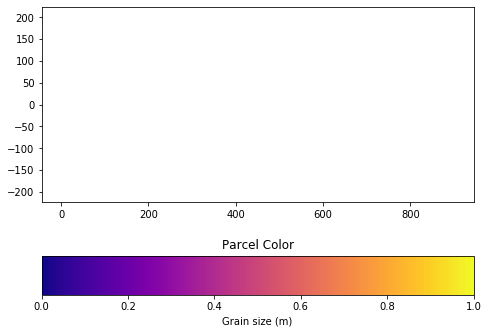

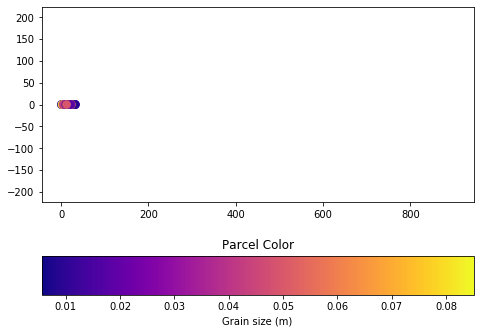

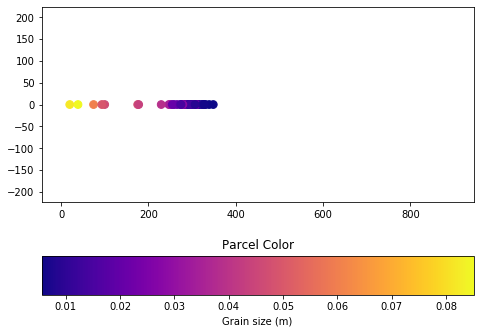

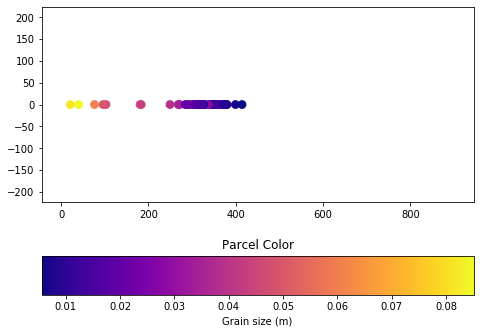

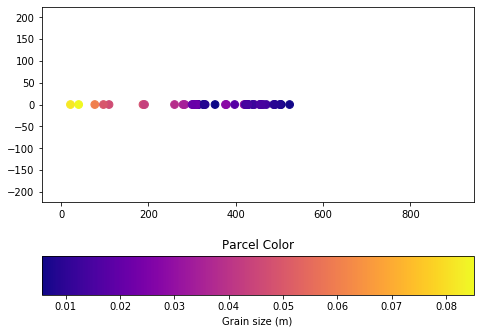

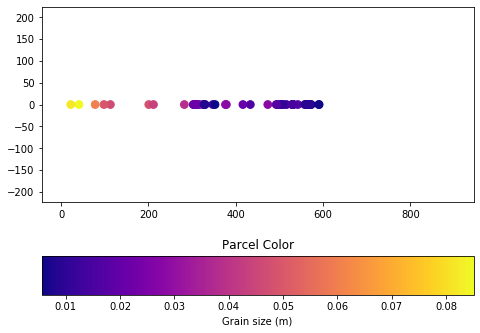

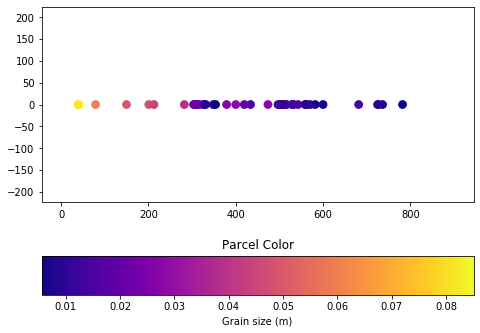

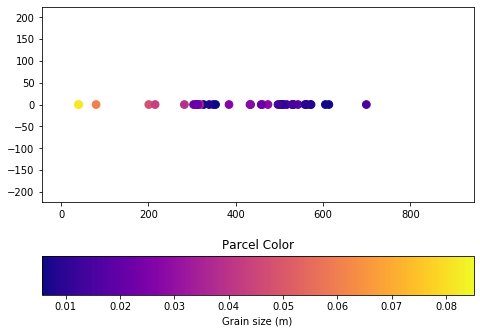

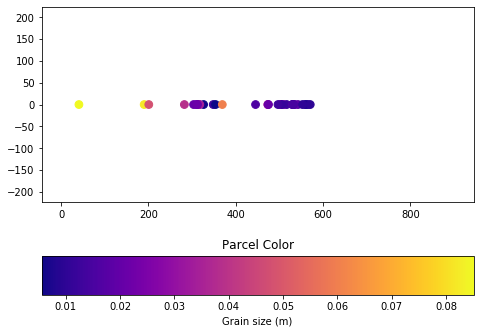

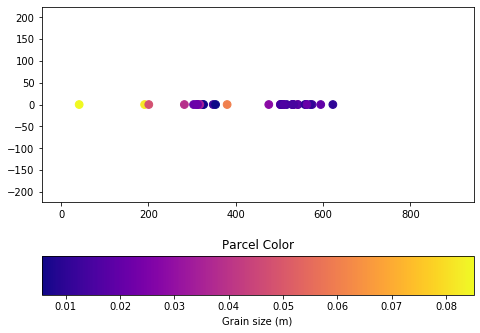

In [7]:
timesteps = 30
dt = 60 * 60 * 24 *3# (seconds) timestep
pulsetime = 3
num_pulse_parcels = 50

for t in range(0, (timesteps * dt), dt):
    start_time = measuretime.time()

    # Run the NST component
    nst.run_one_step(dt)
    
    if t == dt*pulsetime:
        print("Now let's add new parcels!")
        
        new_parcels,nst = add_new_parcels(num_pulse_parcels,nst)
    
     
    
    if (t/dt-pulsetime)%3 == 0:
        pfilter = parcels.dataset['lithology']=='pulse_material'
    
        fig = plot_network_and_parcels(grid, 
                                       parcels,  
                                       parcel_filter=pfilter,
                                       network_color='w',
                                       network_linewidth=4,
                                       parcel_alpha=1.0, 
                                       parcel_color_attribute="D",
                                       parcel_color_attribute_title="Grain size (m)",
                                       parcel_size=60,
                                       )   

In [8]:
parcels.dataset

<xarray.Dataset>
Dimensions:               (item_id: 500, time: 31)
Coordinates:
  * time                  (time) float64 0.0 2.592e+05 ... 7.517e+06 7.776e+06
  * item_id               (item_id) int64 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    grid_element          (item_id, time) object 'link' 'link' ... 'link' 'link'
    element_id            (item_id, time) float64 0.0 0.0 0.0 ... -2.0 -2.0 -2.0
    starting_link         (item_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    abrasion_rate         (item_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    density               (item_id) float64 2.65e+03 2.65e+03 ... 2.65e+03
    lithology             (item_id) object 'quartzite' ... 'pulse_material'
    time_arrival_in_link  (item_id, time) float64 0.5488 0.5488 ... 21.0 21.0
    active_layer          (item_id, time) float64 1.0 0.0 0.0 ... 0.0 0.0 0.0
    location_in_link      (item_id, time) float64 0.2966 0.2966 ... nan nan
    D                     (item_id, time) float64 0.05237 0.05237 ... 0.04954
    volume                (item_id, time) float64 1.0 1.0 1.0 ... 0.05 0.05 0.05

In [14]:
cur_parcels = parcels.dataset.isel(time = parcels.dataset.dims.get('time')-1) 
cur_parcels.element_id
cur_parcels.grid_element
    
cur_items = {"grid_element": "link", "element_id": cur_parcels.element_id}


In [24]:
time= [parcels.dataset.dims.get('time')-1]
time 
cur_parcels = parcels.dataset.isel(time = time) 
cur_parcels
cur_parcels.element_id
cur_items

{'grid_element': 'link',
 'element_id': <xarray.DataArray 'element_id' (item_id: 500)>
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  3., -2.,  0.,  4.,  0.,  0.,
        -2.,  0.,  0.,  0.,  0.,  0., -2.,  1.,  4.,  0., -2.,  0.,  0.,
         0., -2.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0., -2.,  5.,
        -2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  7., -2.,
        -2.,  1.,  1.,  1.,  5.,  1.,  1.,  1.,  1.,  1.,  6.,  1.,  1.,
        -2., -2.,  1.,  7.,  1., -2.,  1., -2.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., -2., -2.,  1.,  1.,  1.,  1., -2.,  1.,
        -2.,  1., -2.,  1.,  1.,  4.,  1., -2.,  1., -2.,  2., -2., -2.,
         2.,  2.,  2.,  2.,  2., -2.,  2., -2.,  6.,  2., -2.,  2., -2.,
         4.,  6., -2., -2.,  2., -2.,  2.,  2.,  2.,  2.,  2.,  7.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2., -2.,  2.,  2.,
        -2., -2., -2.,  2., -2.,  3.,  3.,  3., -2.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,

In [25]:
def reset_parcels_nst(parcels,grid):
    # parcels._dataset=cur_parcels
    _OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1
    time = [parcels.dataset.dims.get('time')-1]   
    print(time)
    cur_parcels = parcels.dataset.isel(time = time) 
        
    cur_items = {"grid_element": "link", "element_id":cur_parcels.element_id}

    variables = {
            "starting_link": (["item_id"], cur_parcels.variables["starting_link"].values),
            "abrasion_rate": (["item_id"], cur_parcels.variables["abrasion_rate"].values),
            "density": (["item_id"], cur_parcels.variables["density"].values),
            "lithology": (["item_id"], cur_parcels.variables["lithology"].values),
            "time_arrival_in_link": (["item_id", "time"], np.expand_dims(cur_parcels.variables["time_arrival_in_link"].values ,axis=1)),
            "active_layer": (["item_id", "time"], np.expand_dims(cur_parcels.variables["active_layer"].values ,axis=1)),
            "location_in_link": (["item_id", "time"], np.expand_dims(cur_parcels.variables["location_in_link"].values ,axis=1)),
            "D": (["item_id", "time"], np.expand_dims(cur_parcels.variables["D"].values ,axis=1)),
            "volume": (["item_id", "time"], np.expand_dims(cur_parcels.variables["volume"].values ,axis=1)),
        }
    #print(variables)
    
    chunk_parcels = DataRecord(
    grid=grid,
    items=cur_items,
    time=time,
    data_vars=variables,
    dummy_elements={"link": [_OUT_OF_NETWORK]},
    )
    
    nst = NetworkSedimentTransporter(    
    grid,
    chunk_parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
    )

    
    return nst, parcels, variables

In [26]:
len(variables['starting_link'][1])

450

c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:541: RuntimeWarning: invalid value encountered in power
  0.515 * self._d_mean_active * (3.09 * (taustar - 0.0549) ** 0.56)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:854: RuntimeWarning: invalid value encountered in less
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:877: RuntimeWarning: invalid value encountered in greater_equal
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\plot\network_sediment_transporter\plot_network_and_parcels.py:476: UserWarning: Attempting to set identical bottom

Model time:  0.0 days passed
Elapsed: 0.013949588934580485  minutes



c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:854: RuntimeWarning: invalid value encountered in less
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:877: RuntimeWarning: invalid value encountered in greater_equal
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:541: RuntimeWarning: invalid value encountered in power
  0.515 * self._d_mean_active * (3.09 * (taustar - 0.0549) ** 0.56)


Model time:  3.0 days passed
Elapsed: 0.004266627629597982  minutes



c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:854: RuntimeWarning: invalid value encountered in less
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:877: RuntimeWarning: invalid value encountered in greater_equal
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:541: RuntimeWarning: invalid value encountered in power
  0.515 * self._d_mean_active * (3.09 * (taustar - 0.0549) ** 0.56)


Model time:  6.0 days passed
Elapsed: 0.004016677538553874  minutes



c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:1123: RuntimeWarning: invalid value encountered in less
  if np.any(np.asarray(taursg < 0)):
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:854: RuntimeWarning: invalid value encountered in less
  * (distance_left_to_travel > 0.0)
c:\users\cband\github\landlab\landlab\components\network_sediment_transporter\network_sediment_transporter.py:877: RuntimeWarning: invalid value encountered in greater_equal
  * (distance_left_to_travel > 0.0)


Now let's add new parcels!


c:\users\cband\github\landlab\landlab\plot\network_sediment_transporter\plot_network_and_parcels.py:476: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(ylim)


[38]


ValueError: You have passed a non-integer element_id to DataRecord, this is not permitted

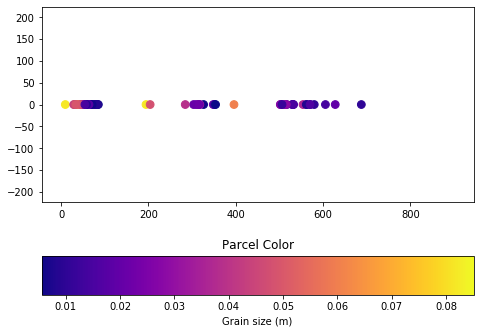

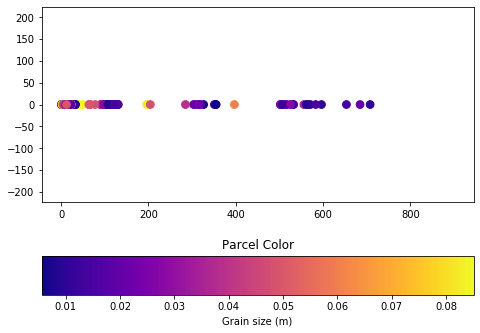

In [27]:
timesteps = 6
dt = 60 * 60 * 24 *3# (seconds) timestep
pulsetime = 3
num_pulse_parcels = 50

for t in range(0, (timesteps * dt), dt):
    start_time = measuretime.time()

    # Run the NST component
    nst.run_one_step(dt)
    
    if t == dt*pulsetime:
        print("Now let's add new parcels!")
        
        new_parcels,nst = add_new_parcels(num_pulse_parcels,nst)
    
     
   
    # Plot pulse parcel locations every few timesteps
    if (t/dt-pulsetime)%3 == 0:
        pfilter = parcels.dataset['lithology']=='pulse_material'
    
        fig = plot_network_and_parcels(grid, 
                                       parcels,  
                                       parcel_filter=pfilter,
                                       network_color='w',
                                       network_linewidth=4,
                                       parcel_alpha=1.0, 
                                       parcel_color_attribute="D",
                                       parcel_color_attribute_title="Grain size (m)",
                                       parcel_size=60,
                                       )   
        
    # Save pulse parcel locations every few timesteps
    if (t/dt-pulsetime)%6 == 0:
        
        #Save to netcdf grid
        iter_Cur = np.round(t/dt)
        
        parcels.dataset.to_netcdf('NST_parcel_iter_' + str(iter_Cur) + '.nc')
        
        #Remove all parcels but the current one and reset the parcels and nst
             
        parcels, nst, variables = reset_parcels_nst(parcels,grid)                
        
        
    print("Model time: ", t/(60*60*24), "days passed")
    print('Elapsed:', (measuretime.time() - start_time)/60 ,' minutes')
    print()

In [19]:
parcels.dataset

<xarray.Dataset>
Dimensions:               (item_id: 550, time: 35)
Coordinates:
  * item_id               (item_id) int64 0 1 2 3 4 5 ... 545 546 547 548 549
  * time                  (time) float64 0.0 2.592e+05 ... 8.554e+06 8.813e+06
Data variables:
    grid_element          (item_id, time) object 'link' 'link' ... nan 'link'
    element_id            (item_id, time) float64 0.0 0.0 0.0 ... nan nan 0.0
    starting_link         (item_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    abrasion_rate         (item_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    density               (item_id) float64 2.65e+03 2.65e+03 ... 2.65e+03
    lithology             (item_id) object 'quartzite' ... 'pulse_material'
    time_arrival_in_link  (item_id, time) float64 0.5488 0.5488 ... 8.813e+06
    active_layer          (item_id, time) float64 1.0 0.0 0.0 ... nan nan 1.0
    location_in_link      (item_id, time) float64 0.2966 0.2966 ... nan 0.1212
    D                     (item_id, time) float64 0.05237 0.05237 ... 0.04954
    volume                (item_id, time) float64 1.0 1.0 1.0 ... nan nan 0.05

In [ ]:
print(parcels.dataset.dims.get('time')-1)
cur_parcels.element_id
cur_parcels.grid_element
